La startup “Avis Restau”, qui met en relation des clients et des restaurants, souhaite améliorer sa plateforme avec une nouvelle fonctionnalité de collaboration. 

![Restau](images/restau.png)

Les utilisateurs pourront par exemple poster des avis et des photos sur leur restaurant préféré. Ce sera aussi l’occasion, pour l’entreprise, de mieux comprendre les avis postés par les utilisateurs.

Voici les différentes étapes que nous allons réaliser :

- analyser les commentaires négatifs pour détecter les différents sujets d’insatisfaction :
- sélection de quelques milliers de commentaires négatifs,
- prétraitement des données textuelles,
- utilisation de techniques de réduction de dimension,
- visualisation des données de grandes dimensions afin de détecter des mots-clés et sujets d’insatisfaction ;


Analyser les photos pour déterminer les catégories des photos : 
- sélection de 100 à 200 photos par catégorie,
- prétraitement des images. Nous allons tester deux approches, une par extraction de descripteurs (SIFT, ORB ou SURF) et une par Transfer Learning d’un réseau de neurones de type CNN,
- utilisation de techniques de réduction de dimension,
- visualisation des données de grandes dimensions en mettant en évidence les catégories des images,
- vérification que les images sont correctement regroupées selon les catégories en réalisant un clustering, puis une comparaison des clusters avec les catégories des images, via un graphique et une mesure. Nous allons analyser également quelles sont les catégories les mieux regroupées,
Cette vérification nous permettra de conclure sur la faisabilité de réaliser ultérieurement une classification supervisée, nous avons bien compris qu’il n’était pas nécessaire à ce stade de réaliser cette classification supervisée ;

- collecter un échantillon de données (environ 200 restaurants et leurs revues) via l’API Yelp :
- récupérer uniquement les champs nécessaires,
- stocker les résultats dans un fichier exploitable (par exemple CSV).

# Exploration des jeux de données

## Importation des librairie

In [1]:
import pandas as pd
import os
import json
import ijson
from IPython.display import display, Image
from PIL import Image

from os import listdir
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm

from sklearn import preprocessing
%matplotlib inline

## Lecture des ressources

In [2]:
# Liste des fichiers avec lesquels nous allons travailler
print(os.listdir("data/yelp_dataset"))
print(os.listdir("data/yelp_photos"))

['clean_json', 'csv', 'Dataset_User_Agreement.pdf', 'yelp_academic_dataset_business.json', 'yelp_academic_dataset_checkin.json', 'yelp_academic_dataset_review.json', 'yelp_academic_dataset_tip.json', 'yelp_academic_dataset_user.json']
['Dataset_User_Agreement.pdf', 'photos', 'photos.json', 'training_set', 'tsne.csv', 'validation_set']


Nous avons donc 5 fichiers json au total. Selon la décimation de yelp (https://www.yelp.com/dataset/documentation/main), voici en quoi consiste chacun de ces fichiers :

- **yelp_academic_dataset_business.json**: Contiens des données commerciales, notamment des données de localisation, des attributs et des catégories.
- **yelp_academic_dataset_checkin.json**:Vérification entreprise.
- **yelp_academic_dataset_review.json**: Contiens les données complètes du texte de l'avis, y compris le nom de l'utilisateur qui a écrit l'avis et le nom de l'entreprise pour laquelle l'avis a été écrit.
- **yelp_academic_dataset_tip.json**: Conseils écrits par un utilisateur sur une entreprise. Les conseils sont plus courts que les avis et tendent à transmettre des suggestions rapides.
- **yelp_academic_dataset_user.json**: Données de l'utilisateur, y compris la cartographie des amis de l'utilisateur et toutes les métadonnées associées à l'utilisateur.

Chaque variable des json sont détaillées dans la documentation du site.

Nous avons plusieurs fichiers Json.
Cependant, certains sont très gros, nous allons donc en tirer seulement une partie à l'aide d'un **chunk**.

Nous allons donc attribuer un fichier par dataframe puis nous placerons ces dataframe dans un dictionnaire.

Nous pourrons ainsi continuer notre exploration. Nous n'utiliserons que les données du json **business** et **review**.

In [3]:
# Place la liste des fichiers contenus dans nos fichiers de jeu de données
# dans des listes
data_yelp_dataset = os.listdir("data/yelp_dataset")
data_yelp_photos = os.listdir("data/yelp_photos")

In [4]:
data_yelp_dataset = [
    'yelp_academic_dataset_business.json',
    'yelp_academic_dataset_review.json',
]

In [5]:
dict_df = {}


def json_to_df(liste, folder, chunksize):
    for i in liste:
        # Condition qui permet de ne lire que les fichiers json et de ne pas
        # lire le fichier json non propre (business)
        if i[-5:-1] == '.jso':
            # Place dans la variable df un objet Json avec un nombre de chunk
            df = pd.read_json('data/' + folder + '' + i + '',
                              lines=True,
                              orient='record',
                              chunksize=chunksize)
            print(df)
            # Parcours l'objet json et place la dataframe dans le dictionnaire
            # 'dict_df'
            for y in df:
                dict_df[str(i)] = y
                break

In [6]:
json_to_df(data_yelp_dataset, 'yelp_dataset/', 1000000)

In [7]:
dict_df.keys()

dict_keys(['yelp_academic_dataset_business.json', 'yelp_academic_dataset_review.json'])

Nous avons maintenant toutes nos données texte en dataframe.

Passons aux données photos, nous n'avons qu'un seul fichier json à passer dans une dataframe.

In [8]:
dict_df_photo = {}

df = pd.read_json('data/yelp_photos/photos.json',
                  lines=True,
                  orient='record',
                  chunksize=15000)
print(df)
# Parcours l'objet json et place la dataframe dans le dictionnaire
# 'dict_df_photo'
for y in df:
    dict_df_photo['photos.json'] = y
    break

In [9]:
dict_df_photo['photos.json']

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food
...,...,...,...,...
14995,VMYtxjWh52vCKuZz9HKp9g,YMxOjiZfWyN94L8XkZGPRQ,"Bacon, egg and cheese sandwich with avocado added",food
14996,1nxRvbtwcxSao2Vm-JMQ_w,LD-IB5vYI18lEA-QlKY6tA,Large vanilla cone,food
14997,czXD1Z8vkvzTJvy3ewdxuA,ZBTVbCcc8OabC9Q5rIaGlw,Million Dollar Bacon,food
14998,8hXXeqSCLulcC6jptOyNdg,4SRl5od0lY33oK1GMbA23A,Husk burger for happy hour ($10),food


Nos données sont maintenant chargées.

Nous avons aussi d'autres ressources que des json : 

- **Les conditions générales de yelp en pdf.**
- **Des photos en format png**

Nous avons dans notre dataframe 'photos.json' des id de photos, voyons si cela correspond aux noms des photos que nous avons.

In [10]:
os.listdir("data/yelp_photos/photos")

['--0h6FMC0V8aMtKQylojEg.jpg',
 '--3JQ4MlO-jHT9xbo7liug.jpg',
 '--3P3fjPrScy06XVLi4vhg.jpg',
 '--4DfhW2sJvjeC90KEDX3g.jpg',
 '--5V3mRlhb3zqE5yF4Gpaw.jpg',
 '--7SiWWk_OHbdmcU4pNDQw.jpg',
 '--8pNvGp9ICBjJVck2OnTQ.jpg',
 '--9cH8_rrskfmYvONaJpgQ.jpg',
 '--9zKbcEd-DXH4ZUiEI4UA.jpg',
 '--AU_cPMgrWSPluP1v8n_Q.jpg',
 '--CXLzKP6hhYVs54GVOT0Q.jpg',
 '--cxOTSQzInwUOAPwceUuA.jpg',
 '--dacvi4Y_8ACp-10nafMA.jpg',
 '--dM6T1gVl050fS_vkV3Xg.jpg',
 '--DqlLaO1I0D7uFgvRInww.jpg',
 '--e8vgtonVwPXG3n6lfBLA.jpg',
 '--EjX0WhEFSDVv9mtAeiOQ.jpg',
 '--FrnLlpbF2_dRRlZ_dovg.jpg',
 '--Giyv3aAypzllFEp5d8Eg.jpg',
 '--gjH9oA92f7OuTSovXjCg.jpg',
 '--GXT_8apxBAs7epcHf-zA.jpg',
 '--hMxFnB1b_UeDwzsOCmCA.jpg',
 '--HO-fMoTVbYnxVZdWAIGQ.jpg',
 '--I-ThZdBaYfbSlAQhfOfQ.jpg',
 '--IHD2ZgFPfFMR4qMkLzFA.jpg',
 '--j4xVIdIlYpOmZbs7iszg.jpg',
 '--J8VXQsdPNxPXKCRyqakg.jpg',
 '--k9FyNj0Ztr08wutGppYA.jpg',
 '--Kofko5jy33_vPJOEt4Ow.jpg',
 '--KPaOH7QLrQ1DliVmoacA.jpg',
 '--kP__1IcWsQE0ycWKT0bg.jpg',
 '--lRwPamtV4WMbl3MMhRCw.jpg',
 '--MwzZ

In [11]:
# Nous parcourons les 5 premières lignes de notre df photo
for i in dict_df_photo['photos.json']['photo_id'].head(5):
    # Nous ajoutons l'extension de photos à leurs id pour qu'elles puissent
    # être trouvées si elles existent
    i = i + '.jpg'
    if i in os.listdir("data/yelp_photos/photos"):
        print(True)

True
True
True
True
True


Très bien, l'id et le nom des photos correspondent bien.
Par simple curiosité, regardons ces photos.

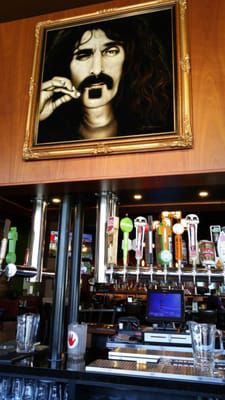

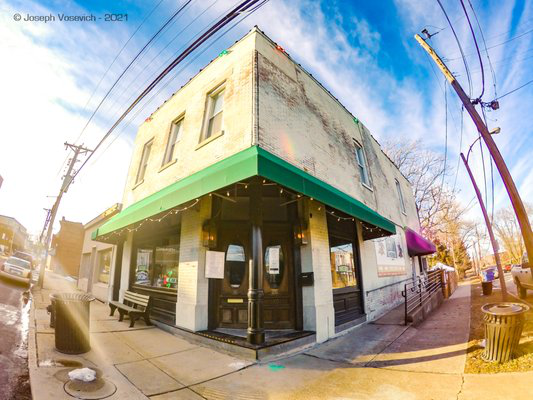

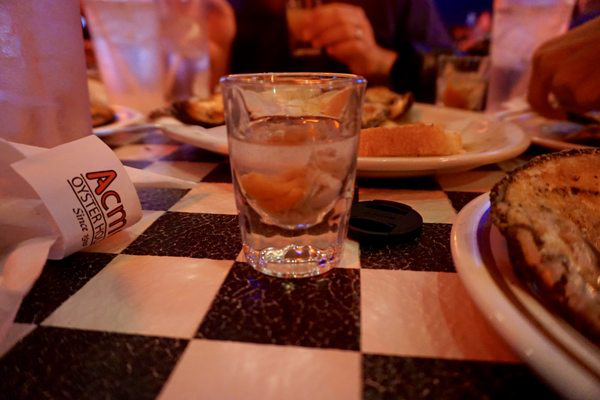

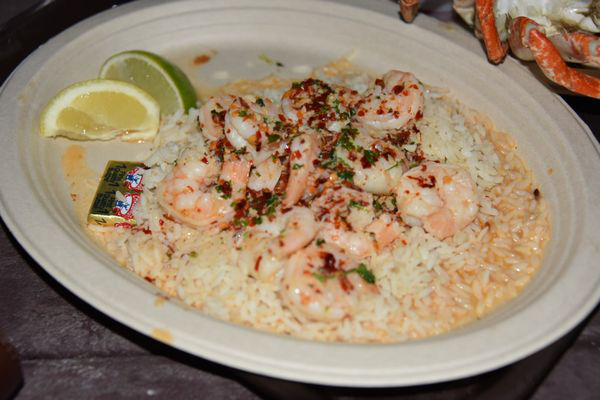

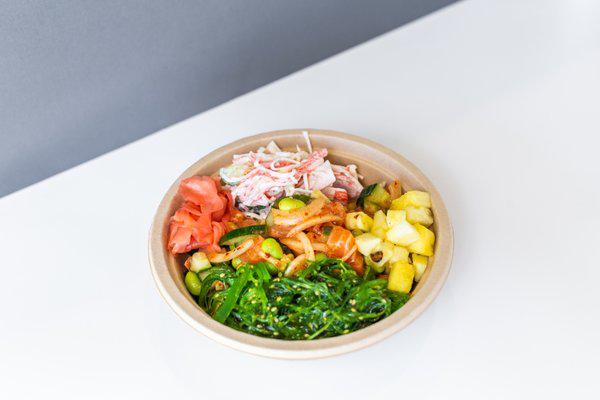

In [12]:
liste_images = []
for i in dict_df_photo['photos.json']['photo_id'].head(5):
    i = 'data/yelp_photos/photos/' + i + '.jpg'
    liste_images.append(i)
    Image.open(i)

for image in liste_images:
    img = Image.open(image)
    display(img)

In [13]:
liste_images

['data/yelp_photos/photos/zsvj7vloL4L5jhYyPIuVwg.jpg',
 'data/yelp_photos/photos/HCUdRJHHm_e0OCTlZetGLg.jpg',
 'data/yelp_photos/photos/vkr8T0scuJmGVvN2HJelEA.jpg',
 'data/yelp_photos/photos/pve7D6NUrafHW3EAORubyw.jpg',
 'data/yelp_photos/photos/H52Er-uBg6rNrHcReWTD2w.jpg']

Cela fonctionne, mais nous verrons tout ça plus tard.

Nous avons les différentes ressources de notre jeu de données.

In [14]:
df_review = dict_df['yelp_academic_dataset_review.json']
df_business = dict_df['yelp_academic_dataset_business.json']

# Séléction des données 

Nous avons besoin de ne garder que les review de restaurant, nous allons donc ajouter la colonne catégorie qui se trouve dans la dataframe **'df_business'** et l'ajouter à la dataframe **"df_review"** avec l'id **"business_id"**.

In [15]:
df_business_id = df_business[["business_id", "categories"]]
df_business_id

,business_id,categories
0,Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,"Brewpubs, Breweries, Food"
...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,"Nail Salons, Beauty & Spas"
150342,c8GjPIOTGVmIemT7j5_SyQ,"Pets, Nurseries & Gardening, Pet Stores, Hobby..."
150343,_QAMST-NrQobXduilWEqSw,"Shopping, Jewelry, Piercing, Toy Stores, Beaut..."
150344,mtGm22y5c2UHNXDFAjaPNw,"Fitness/Exercise Equipment, Eyewear & Optician..."


In [16]:
df_review_merge = df_review.merge(df_business_id,
                                  left_on='business_id',
                                  right_on='business_id')
df_review_merge = df_review_merge.drop_duplicates(
    subset=['business_id']).reset_index()
df_review_merge = df_review_merge.drop('index', axis=1)

In [17]:
df_review_merge

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,categories
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,"Restaurants, Breakfast & Brunch, Food, Juice B..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,"Active Life, Cycling Classes, Trainers, Gyms, ..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,"Restaurants, Breakfast & Brunch"
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,"Halal, Pakistani, Restaurants, Indian"
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ..."
...,...,...,...,...,...,...,...,...,...,...
27090,TKCu3981Rkcx2bDcfyZ9pg,LirfE6OHZY316c1oWwfMaw,t7-cdopPQauHDNPlaDiz2A,5,0,0,0,A great store run by a beautiful caring family...,2016-11-09 12:07:06,"Food, Restaurants, Specialty Food, Russian"
27091,GsWD4zYwWylmXTP4nwLcWg,CwnMLEwolfs6w83bz758sA,9r4o_OFUZciqo4uoUCoBZA,1,13,9,6,Worst first class ever! Started in SF where we...,2017-05-26 21:56:19,"Transportation, Airports, Airlines, Hotels & T..."
27092,oGT8-8lGkgc0BCNN0uovWg,VhGCdyXeOx8IkCH1Y5Acew,7qaFHtRXG7X-msIJjlosig,1,0,0,0,Grossly negligent. I'm the owner of a small co...,2017-08-28 16:57:23,"Lawyers, Financial Services, Professional Serv..."
27093,Ccj9IOsS4S5k4s4UO6kQRQ,mUsoSF5P4ssJfSQS4sDdhw,I21dVOT3pxwQVPECxRIJiA,5,1,0,1,Order breakfast from here all the time. Great ...,2014-06-20 14:07:11,"Restaurants, Event Planning & Services, Catere..."


Pour la suite de notre projet, nous n'aurons besoin que des commentaires négatifs.

In [18]:
# Sélection des commentaires avec une étoile seulement pour bien avoir les commentaires bien négatifs
# df_review = df_review_merge.drop('Unnamed: 0', axis=1)
df_bad_review = df_review_merge.loc[
    df_review_merge['stars'] < 2].copy().reset_index()
df_bad_review = df_bad_review.drop('index', axis=1)
df_bad_review_cleaning = df_bad_review.copy()

In [19]:
df_bad_review_cleaning

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,categories
0,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,"Mediterranean, Restaurants, Seafood, Greek"
1,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12,"American (New), Restaurants, Mexican"
2,qdzNocGBnh8U-cvE_N8qbA,Fq7d14GDAsGjDoojP_ygOQ,pAgtmlIGqFYaWdBoCUeitw,1,3,0,0,The TV shows are $4.99 and they have commercia...,2012-12-04 02:40:49,"Fashion, Event Planning & Services, Venues & E..."
3,PDHRlnEdkEcwATry4w71PQ,UsBxLh14sUpO8SdeqIiGOA,Wy8Hswf2cLQGRZN6armkag,1,1,0,0,"If I could give it a zero, I would. I order a ...",2011-08-24 23:07:08,"Restaurants, Fast Food, Mexican, Tacos, Burger..."
4,5obXxR0b94b5q6j1zYCAzw,3inG_FUhm28tUJc0zZ2fCg,aY_n9RSaD2Yw09jSFFePew,1,0,0,0,We visited once and were very disappointed in ...,2017-08-16 15:43:19,"Chicken Wings, Restaurants, Beer, Wine & Spiri..."
...,...,...,...,...,...,...,...,...,...,...
4680,svSQjWCyJSOpj2Pj4T9CdA,7yiuwr9gZ3YXWec7Vc_x7Q,REjPVXCgYrNErdAN4ZsFWw,1,2,0,0,Recently used this company to move interstate....,2015-01-11 22:25:41,"Movers, Home Services"
4681,S1qC_b9B9XQnKjgPHvQduA,PAJ8HcqOCviZAoBG1WEIBQ,0niqaT3_u-sJ-VXPsfTYaA,1,5,0,0,HORRIBLE!! I wrote a review before explaining ...,2011-06-14 17:59:49,"Travel Services, Hotels & Travel"
4682,fRfZigzL5Sh7rhM-4ahkwg,8ZNWdZ-aXobtxb6goHR31w,-0jzoPt3UeXn6FUXVQvyPg,1,0,0,0,Went to the movies downtown and decided to gra...,2019-01-16 13:23:09,"American (New), Restaurants"
4683,GsWD4zYwWylmXTP4nwLcWg,CwnMLEwolfs6w83bz758sA,9r4o_OFUZciqo4uoUCoBZA,1,13,9,6,Worst first class ever! Started in SF where we...,2017-05-26 21:56:19,"Transportation, Airports, Airlines, Hotels & T..."


Maintenant nous devons garder seulement les review de restaurants.

In [20]:
df_bad_review_cleaning["categories"].unique()

array(['Mediterranean, Restaurants, Seafood, Greek',
       'American (New), Restaurants, Mexican',
       "Fashion, Event Planning & Services, Venues & Event Spaces, Hotels, Shopping, Hotels & Travel, Women's Clothing",
       ..., 'Travel Services, Hotels & Travel',
       'Transportation, Airports, Airlines, Hotels & Travel',
       'Lawyers, Financial Services, Professional Services, Workers Compensation Law, Tax Services, Accountants, Payroll Services'],
      dtype=object)

In [21]:
df_business["categories"][0]

'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists'

In [22]:
# Ne garde que les reviews contenant le mot "restaurant" dans leur 
# valeur à la colonne "categories"
df_review = df_bad_review_cleaning[
    df_bad_review_cleaning["categories"].str.contains(
        "Restaurants") == True].reset_index()
df_review = df_review.drop('index', axis=1)
df_review

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,categories
0,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,"Mediterranean, Restaurants, Seafood, Greek"
1,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12,"American (New), Restaurants, Mexican"
2,PDHRlnEdkEcwATry4w71PQ,UsBxLh14sUpO8SdeqIiGOA,Wy8Hswf2cLQGRZN6armkag,1,1,0,0,"If I could give it a zero, I would. I order a ...",2011-08-24 23:07:08,"Restaurants, Fast Food, Mexican, Tacos, Burger..."
3,5obXxR0b94b5q6j1zYCAzw,3inG_FUhm28tUJc0zZ2fCg,aY_n9RSaD2Yw09jSFFePew,1,0,0,0,We visited once and were very disappointed in ...,2017-08-16 15:43:19,"Chicken Wings, Restaurants, Beer, Wine & Spiri..."
4,meGaFP7yxQdjyABrYDVeoQ,_jaJDV-qTBafatbObmtzpA,cg4JFJcCxRTTMmcg9O9KtA,1,0,1,0,Skip this train wreck if you are looking for d...,2018-02-11 03:11:20,"Wine Bars, Desserts, Bars, American (New), Nig..."
...,...,...,...,...,...,...,...,...,...,...
1610,_lb4mAjKiszoCcjNjBVjOA,5GMOJ3pT4-ye25qJocHX-Q,E0AKqwkebF15_hvzNSyGlQ,1,1,1,0,We were very excited when they opened up PJ Cl...,2018-10-11 17:04:38,"Bars, American (Traditional), Restaurants, Coc..."
1611,03h4-ERswgpItRpbiaca8g,xhN87RUEVbj-6tiKZBzLnQ,NH-LOS97SfP2aL_ZaLwUJA,1,0,0,0,I don't recommend ordering food from this rest...,2018-11-04 18:11:28,"American (New), Restaurants"
1612,GdrKqxmpJxbTL53JF6EUFw,jt34dBk2I6Em2fv-aEoEbQ,gtlj72UOq-wOSuOfXOCWeg,1,0,0,0,Clumpy meat and soggy bread. Phillys finest I ...,2019-04-12 21:15:58,"Wraps, Chicken Wings, Cheesesteaks, Restaurant..."
1613,98Zf6l29ud44gn6oyd5mLA,VVtxI9sSaGff05J7WNbh5A,ejqpFQ0dwO7AZhxTO9fySg,1,0,0,0,Okay so I'm confused why I paid for a $9 glass...,2019-04-25 20:01:55,"Farmers Market, American (Traditional), Americ..."


Nous allons maintenant exporter nos données pour la suite du projet.

# Nettoyage image

Préparons maintenant notre dataset. Nous avons, pour chaque donnée, une colonne catégorie.

Nous allons pré-encoder nos labels pour le notebook sur l'analyse d'image, ainsi que vérifier si les photos présentent dans notre dataframe le sont bien aussi dans notre dossier de photo.

In [23]:
df_photo = pd.read_json('data/yelp_photos/photos.json', lines=True)

# Rename la colonne des labels en 'label_name'
df_photo.rename({'label': 'label_name'}, axis=1, inplace=True)

# Encode les valeurs de label_name et les places dans une nouvelle colonne
# "label"
le = preprocessing.LabelEncoder()
df_photo["label"] = le.fit_transform(df_photo["label_name"])
df_photo

,photo_id,business_id,caption,label_name,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside,2
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside,4
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink,0
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food,1
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food,1
...,...,...,...,...,...
200095,4Zia9NkAfQNjMfcIDhwJ-g,2HxkdqHmbYGj_BH1bLaiSw,#Nektar,food,1
200096,KB96KRZRhRm8hUkI-OpGEA,_gVyuTRb_6HM-SNtqbpevQ,,inside,2
200097,Klmojvaf2_2dP1XKzTsFmQ,NUyEOjfAl3HvkpzSpdwqeA,,food,1
200098,FNEiq7Mogec7t31OaU5juw,hE6YsHHV0fCz_UrGS4o6VA,Drinks by the water!,drink,0


In [24]:
path = "data/yelp_photos/photos/"
list_photos = [file for file in listdir(path)]
print("Nombre total de photos :", len(list_photos))
list_photos[:5]

Nombre total de photos : 200098


['--0h6FMC0V8aMtKQylojEg.jpg',
 '--3JQ4MlO-jHT9xbo7liug.jpg',
 '--3P3fjPrScy06XVLi4vhg.jpg',
 '--4DfhW2sJvjeC90KEDX3g.jpg',
 '--5V3mRlhb3zqE5yF4Gpaw.jpg']

In [25]:
df_photo["label_name"].value_counts()

food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: label_name, dtype: int64

Voyons si toutes les photos présentes dans notre dataframe se trouvent bien dans notre fichier et si elles ne sont pas corrompues.

In [26]:
%%time
liste_image_corrompu = []
for image_num in tqdm(range(len(df_photo))):
    try:
        image = Image.open('data/yelp_photos/photos/' +
                           df_photo.iloc[image_num].photo_id + '.jpg')
    except:
        liste_image_corrompu.append(df_photo.iloc[image_num].photo_id)
        continue

len(liste_image_corrompu)

  0%|          | 0/200100 [00:00<?, ?it/s]

CPU times: user 1min 59s, sys: 37.5 s, total: 2min 37s
Wall time: 17min 6s


106

In [27]:
liste_image_corrompu

['ydm3g1wUWSxJnMPgHk2JhQ',
 'JGpfPj8VEvnq1B-Xqr3w-A',
 'bf3ymV0YgP7B6rEoriaU2w',
 'juDNZOOnkgG3QINFrulsAg',
 '9X4YPM8nYFjf7hY8xUdc6Q',
 'N6hL8FQ84A2DznF2S2Lp7g',
 'pY32hIagdxrL4Nsi959EQg',
 'cNkUV0sInfh_Py5PP8SHtQ',
 'Pk87_8Yndygr4LRUD_H7Hg',
 'ke4ohxa93GJz0KH9H2kwsQ',
 'rLafN9k3_AF5lZU0cs3LZg',
 '-YAvSvGUs2ugiJUvIRO6Jw',
 'feUGw0P5byOq4U40C77tyQ',
 'pW1IPuTdLIUB61goirbXaA',
 'RLtBKD2rlfTaELWejmLBCA',
 'IB2ZjqjtS1W_DadQoPPdgg',
 '43fHlHSYQ_79OBJW1aVUxA',
 'QhATx1B1n8uf8C6siMNTfA',
 '9RDbbAZB0HnL4hndCWB58w',
 '1wd_eyhMrTqUmicDmn4_Kw',
 'W94rrCn0O5K1lkfD26m4tw',
 'n6Q9vNuxz7786ESEfautxQ',
 'YW1WMOkVbdFBrixDnKgoqA',
 'hjEfal2a1DWRDu8_AUDLNg',
 '0TpeNZPs3Gu8s30KVXudcg',
 'AMSyCOP3-Eb_ivNA8w1Vhw',
 'TvD36_DdnyCJuXV1SSt3_Q',
 'rrfwGSwt3eHxxypfu5PGTA',
 'qMlGILrsrzhMDxajNYiyIA',
 'jU-dKl2Ye4L_5x602yoctQ',
 'TN4-gAea6ejAdZ-NzYXxng',
 'IkGbGxI8IoOCuVsNB0VLrA',
 'nKJ7yiPc0E_DJNtNxmCrhg',
 'E7Wpzn-1fCnVJ8_zKpecPQ',
 'MduVueqYTBlEkX-axrh1ug',
 'ytJ4lihJrvyzMMRG-WwDNw',
 '-BIybLxzoFt2d2zbYRcfHA',
 

Nous allons maintenant supprimer les images contenues dans la liste "liste_image_corrompu".

In [28]:
%%time
for i in liste_image_corrompu:
    df_photo = df_photo[df_photo["photo_id"].str.contains(i) == False]

CPU times: user 13.1 s, sys: 0 ns, total: 13.1 s
Wall time: 13.1 s


Nous avons environ 200000 photos au total et 5 catégories différentes.

In [29]:
df_photo.to_csv(r'data/yelp_dataset/csv/df_photo.csv')
df_review.to_csv(r'data/yelp_dataset/csv/df_review.csv')
df_business.to_csv(r'data/yelp_dataset/csv/df_business.csv')